# Aperiodic electrophysiological activity tracks spiking statistics between behavioral states
Sawyer Figueroa, Michael Preston, Bradley Voytek

# SfN 2023, Poster Panel 3
This notebook reproduces the figures from poster panel 3. Panel 3 compares spiking statistics between cognitive and behavioral states.

Dataset: Allen Institute for Brain Science: Visual Coding - Neuropixels  
© 2015 Allen Institute for Brain Science. Allen Brain Atlas API. Available from: https://portal.brain-map.org/explore/circuits/visual-coding-neuropixels

## Set-up

### set paths

In [1]:
# settings - directories
PROJECT_PATH = 'G:/Shared drives/visual_encoding'

### imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [4]:
# custom
import sys
sys.path.append("../../")
from allen_vc.plots import sync_plot
from allen_vc.stats import sync_stats

print("Packages Imported")

Packages Imported


### Settings

In [5]:
# matplotlib and figure appearance settings
plt.style.use(f'../../stylelib/sfn_2023.mplstyle')
# COLORS = ["#7570b3", "#3FAA96", "#F39943"]


## Main

### load results

In [6]:
# load spike stats
metric_fp = f'{PROJECT_PATH}/data/spike_data/synchrony_data/VISp-LGd_spontaneous.csv'
metric_df = pd.read_csv(metric_fp)
metric_df

,mean_firing_rate,unit_firing_rates,coefficient_of_variation,spike_distance,spike_synchrony,correlation_coefficient,epoch_times,epoch_idx,running,brain_structure,session
0,5.331765,"[0.8333333333333334, 0.13333333333333333, 0.1,...",1.055501,0.380799,0.158045,[[ 1. -0.15016481 -0.04578685 ... ...,"[array(4404.24179622) * s, array(4434.24179622...",0,above,VISp,771160300
1,5.161961,"[2.7, 0.4, 0.06666666666666667, 14.06666666666...",1.075214,0.382629,0.147907,[[ 1. 0.51544281 0.12428076 ... -0.0...,"[array(4501.96179622) * s, array(4531.96179622...",1,above,VISp,771160300
2,5.332941,"[0.3333333333333333, 0.06666666666666667, 0.1,...",1.084709,0.384524,0.148880,[[ 1. -0.0805823 -0.10050378 ... -0.0...,"[array(4753.44179622) * s, array(4783.44179622...",2,above,VISp,771160300
3,4.910980,"[1.5, 0.3, 0.43333333333333335, 9.9, 5.5666666...",1.094184,0.380435,0.148044,[[ 1. 0.64842596 0.20336844 ... ...,"[array(4783.44179622) * s, array(4813.44179622...",3,above,VISp,771160300
4,5.370980,"[0.6333333333333333, 0.1, 0.3, 11.7, 6.1666666...",1.077314,0.380362,0.145042,[[ 1. -0.08167992 -0.1719245 ... 0.2...,"[array(4966.22179622) * s, array(4996.22179622...",4,above,VISp,771160300
...,...,...,...,...,...,...,...,...,...,...,...
1505,7.351852,"[1.6666666666666667, 7.866666666666666, 21.3, ...",1.057025,0.335776,0.176196,[[ 1. 0.32309325 0.23062856 -0.26305...,"[array(6077.75508127) * s, array(6107.75508127...",50,above,LGd,839068429
1506,7.085185,"[1.5, 8.366666666666667, 19.233333333333334, 8...",1.173945,0.341559,0.180214,[[ 1. 0.21083491 0.14402438 -0.08842...,"[array(6107.75508127) * s, array(6137.75508127...",51,above,LGd,839068429
1507,7.729630,"[1.9333333333333333, 9.266666666666667, 20.0, ...",1.083863,0.338730,0.181121,[[ 1. -0.03072749 -0.00749524 -0.23081...,"[array(6137.75508127) * s, array(6167.75508127...",52,above,LGd,839068429
1508,11.529630,"[7.1, 9.2, 22.7, 9.166666666666666, 11.9, 11.7...",1.035925,0.324067,0.255943,[[ 1. 0.20668745 0.03877156 -0.08130...,"[array(4589.91508127) * s, array(4619.91508127...",0,below,LGd,839068429


### State comparison - compare mean spike stats between states

#### violin plots

In [7]:
def run_labels(s):
    if s == 'above':
        return 'running'
    else:
        return 'stationary'

metric_df['behavior'] = metric_df['running'].apply(run_labels)

In [8]:
# define metrics to be plotted 
# metrics = ['mean_firing_rate', 'coefficient_of_variation', 'spike_distance', 'spike_synchrony']
metrics = ['mean_firing_rate', 'spike_distance']
condition = 'behavior'

In [12]:
# # plot all epocbhs
# sync_plot(metric_df, metrics, condition, markersize=3);

C:\Users\micha\AppData\Roaming\Python\Python37\site-packages\seaborn\categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
C:\Users\micha\AppData\Roaming\Python\Python37\site-packages\seaborn\categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


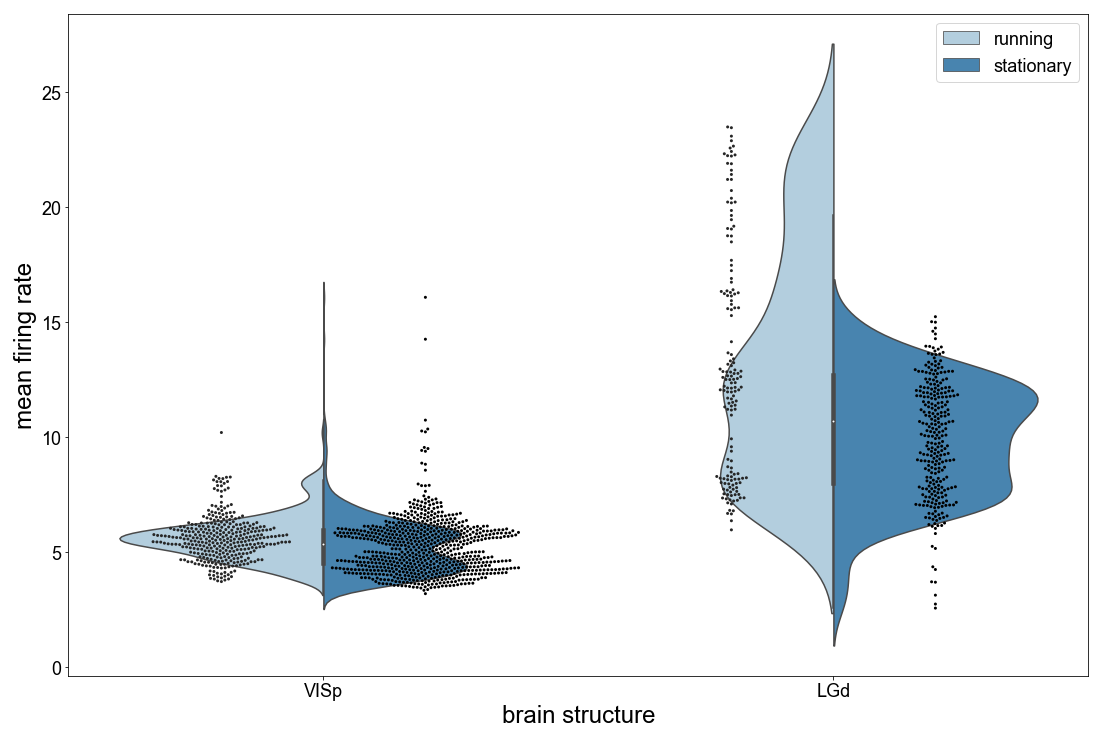

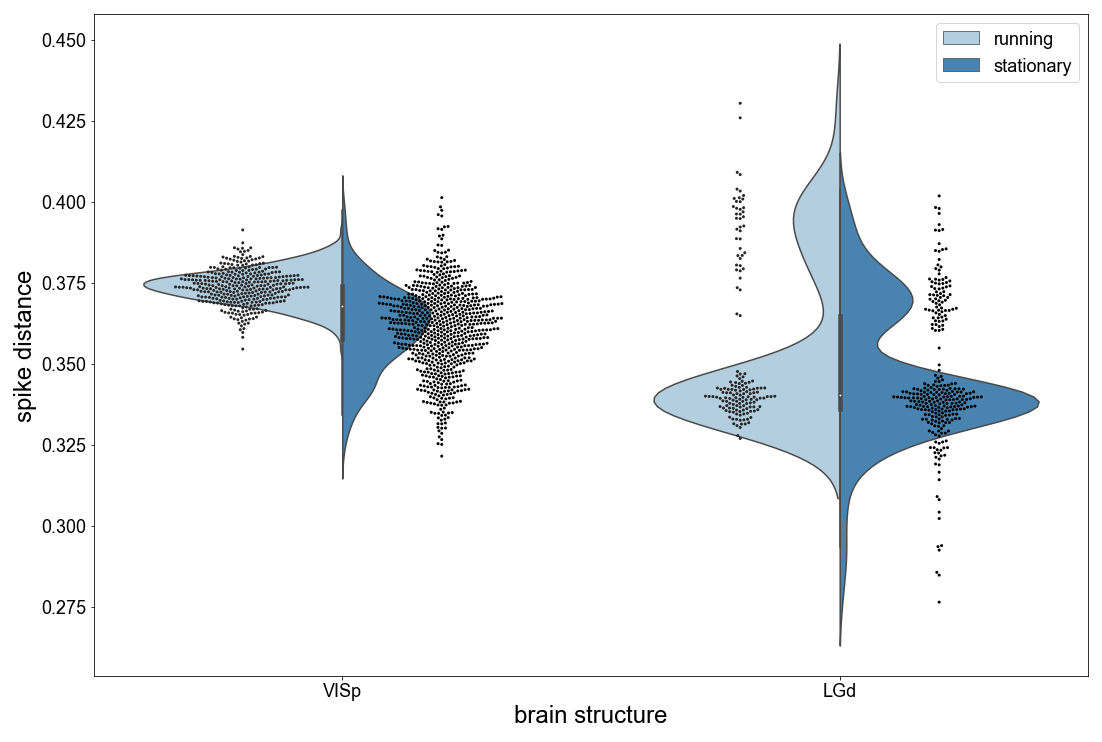

In [10]:
# plot all epochs - without outliers 

# identify clear outliers in SPIKE-distance
metric_df[metric_df['spike_distance'] < 0.25]

# remove outliers
no_outliers_metric_df = metric_df[metric_df['spike_distance'] > 0.25]

# plot
sync_plot(no_outliers_metric_df, metrics, condition, markersize=3);

#plt.savefig("C:/Users/User/Documents/Voytek Lab/posters/figures/all_sessions_metric_violin_plots.png")

C:\Users\micha\AppData\Roaming\Python\Python37\site-packages\seaborn\categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
C:\Users\micha\AppData\Roaming\Python\Python37\site-packages\seaborn\categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


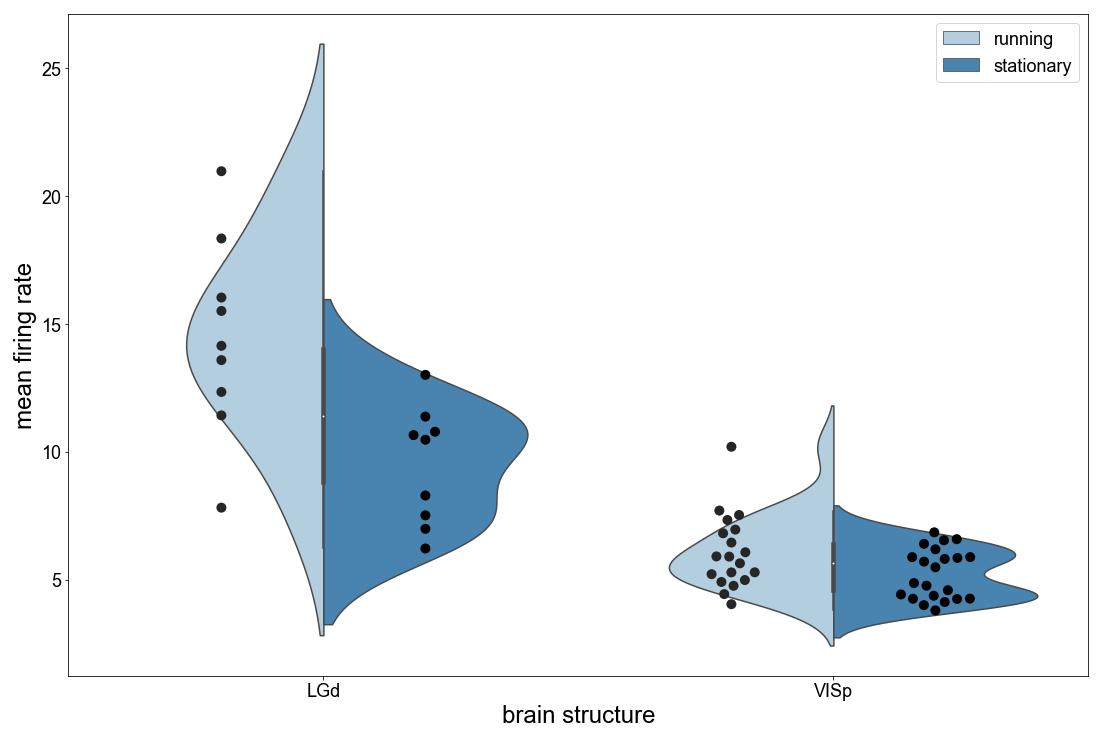

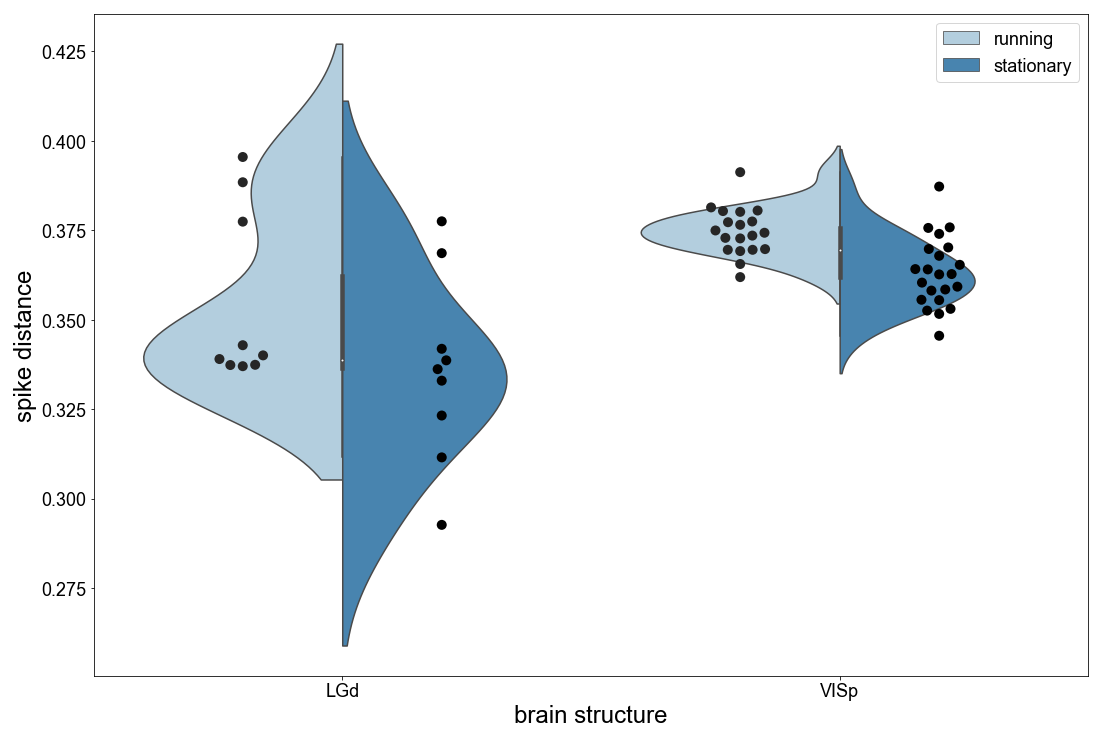

In [11]:
# plot subject average 

# average across trials
ses_avg = metric_df.groupby(['session', 'behavior', 'brain_structure']).mean().reset_index()

# plot
sync_plot(ses_avg, metrics, condition, markersize=10);

### post hoc tests

#### paired t-test

In [13]:
# post hoc tests

# look at diffs between running and stationary
print("ALL DATA\n\n\n")
sync_stats(metric_df, metrics, condition)

ALL DATA



REGION: VISp

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

METRIC: mean_firing_rate

Behavior: running
N = 348
Mean = 5.57341942592551
Stdev = 0.9515792060594441

Behavior: stationary
N = 722
Mean = 5.214426154574993
Stdev = 1.2457287035093207

Independent T-Test (All data)
Ttest_indResult(statistic=4.744933008337741, pvalue=2.368847084553625e-06)


----------------------------------------------------------------------------------------------------

METRIC: spike_distance

Behavior: running
N = 348
Mean = 0.37309347663356063
Stdev = 0.012666216814598457

Behavior: stationary
N = 722
Mean = 0.360624101645374
Stdev = 0.013843219231004636

Independent T-Test (All data)
Ttest_indResult(statistic=14.170400691677855, pvalue=6.77304646820148e-42)


----------------------------------------------------------------------------------------------------

REGION: LGd

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

In [15]:
print("GROUP AVERAGES\n\n\n")
sync_stats(ses_avg, metrics, condition, paired_ttest=True)

GROUP AVERAGES



REGION: LGd

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

METRIC: mean_firing_rate

Behavior: running
N = 9
Mean = 14.458853796240154
Stdev = 3.6483111616732224

Behavior: stationary
N = 9
Mean = 9.474622973120205
Stdev = 2.166419895667726

Independent T-Test (All data)
Ttest_indResult(statistic=3.3224929766177147, pvalue=0.004310108942964574)

Paired T-Test
Ttest_relResult(statistic=3.450236134889917, pvalue=0.008691777104932559)


----------------------------------------------------------------------------------------------------

METRIC: coefficient_of_variation

Behavior: running
N = 9
Mean = 0.9644700544087824
Stdev = 0.10470554715615227

Behavior: stationary
N = 9
Mean = 1.1154748558470304
Stdev = 0.2679284212130762

Independent T-Test (All data)
Ttest_indResult(statistic=-1.484754534728276, pvalue=0.15704320034254074)

Paired T-Test
Ttest_relResult(statistic=-1.6192331298816804, pvalue=0.1440571319621782)

#### hierarchical bootstrap